In [1]:
%load_ext autoreload
%autoreload 2

import glob
import logging
import numpy as np
from importlib import reload  # Not needed in Python 2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.models import ResNet
from torch.utils.data import DataLoader,Dataset


from dataset.ASdataset import AS_Data
from dataset.ASdataset_obs_train_input import AS_Data_obs

from model import res8,UNet,UNet_Res

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
reload(logging)
logging.basicConfig(level=logging.INFO,#控制台打印的日志级别
                    filename='logging.txt',
                    filemode='a',##模式，有w和a，w就是写模式，每次都会重新写日志，覆盖之前的日志
                    #a是追加模式，默认如果不写的话，就是追加模式
                    format=
                    '%(asctime)s : %(message)s',
                    )

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def image_show(im,title = '',r=10,base=80):
    im[:r,:r] = base
    im[r,r] = 0
    im[im>base] = base
    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()
    
# logging.info('\n\n\n\n\n')
# logging.info('with 3 conv grid to concat\n')
# logging.info('2res block, use simple feature: EM inventory simple,2d ALL,3d ALL\n')

class Tensor_Parameter(nn.Module):
    def __init__(self,):
        super(Tensor_Parameter,self).__init__()
        self.Input = nn.Parameter(torch.zeros(1))
    
    def forward(self,x):
        self.Input.data = x
        return self.Input


class Focal_loss_regression(nn.Module):
    def __init__(self,max_update=10,_lambda=2,):
        super(Focal_loss_regression,self).__init__()
        self._lambda = _lambda
        max_update = np.power(1/max_update,1/_lambda)
        max_update = 1/max_update
        max_update = 1/(max_update-1)
        self.max_update = max_update
        
    def forward(self,pred,target):
        diff_abs = torch.abs(pred-target)
        diff_max = (1+self.max_update)*torch.max(diff_abs)
#         diff_max.detach()
        rate = torch.pow((1-1/diff_max*diff_abs)**self._lambda,-1)
        diff_abs = rate*diff_abs
        
#         return diff_abs
        return torch.mean(diff_abs)

In [ ]:

# cfg = {'EM':'/AS_data/Emis_with_foreign_npy/EM_2015_*',
#       'label':'/AS_data/Conc_npy/O3_2015_*',
#       'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
#       'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_*',
#       'METCRO3D':'',
#       'METCRO3D_5height':'',
#       'obs_label':'/AS_data/obs_npy/obs2015_*'}
cfg = {'EM':'/AS_data/Emis_with_foreign_npy/EM_2015_07*',
        'label':'/AS_data/Conc_npy/O3_2015_07*',
        'grid':'/AS_data/Grid_npy/grid_27_182_232.npy',
        'METCRO2D':'/AS_data/METCRO2D_npy/METCRO2D_2015_07*',
        'METCRO3D':'',
        'METCRO3D_5height':'',
        'obs_label':'/AS_data/obs_npy/obs2015_07_*'}

print('train data is loading ')
Data = AS_Data_obs(cfg,left = 0,right = 1,window = 6)
trainloader = DataLoader(Data,batch_size=1,shuffle=True)
print(len(Data))

# print('test data is loading ')
# test_Data = AS_Data_obs(cfg,left = 0.75,right = 0.98,window = 6)
# testloader = DataLoader(test_Data,batch_size=1,shuffle=False)
# print(len(test_Data))

train data is loading 
/AS_data/Conc_npy/O3_2015_07_744_182_232.npy   is loading
/AS_data/Emis_with_foreign_npy/EM_2015_07_744_51_182_232.npy   is loading


In [ ]:
# test_model = res8(51+34,27,inplanes=64,layers = [2],T=24) #+5*16
# name = 'res_2layer_correctdata'
# test_model.load_state_dict(torch.load('model_save/res_2layer_9_epoch.t'))
test_model = UNet(51+34,27,T=6,bilinear=False) #+80
t2p = Tensor_Parameter()

name = 'unet2'

test_model.to(device)
t2p.to(device)
criterion = torch.nn.L1Loss()
# optimizer = torch.optim.Adam(test_model.parameters(),lr=1e-3)
optimizer = torch.optim.Adam(t2p.parameters(),lr=1e-2)
test_model.load_state_dict(torch.load('model_save/o3_with_foreign_unet2_5month_10_epoch.t'))
# test_model.load_state_dict(torch.load('model_save/o3_best_unet2_1month_65_epoch.t'))

In [ ]:
def score(model,loader,criterion= nn.L1Loss() ):
    model.eval()
    ls = []
    for idx,i in enumerate(loader):
        with torch.no_grad():
            indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
            yt_1 = torch.unsqueeze(yt_1,1)
            input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.float().to(device)
            input = t2p(input)
            y_pred = model(input,grid,yt_1)
            y_pred = torch.squeeze(y_pred) #,dim = 2)
            y_pred = y_pred.view(label.shape)
            
            Data.update_labels(indexes,y_pred)
            if torch.sum(obs!=-999)==0:
                continue

            
            loss = criterion(y_pred[obs!=-999],obs[obs!=-999])
            ls.append(loss.cpu().data)
        
    return np.mean(np.array(ls))

In [ ]:
test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
logging.info('-------------cur test loss L1:  {}'.format(test_score_L1))
print('-------------cur test loss L1:  {}'.format(test_score_L1))


for epoch in range(25):
    logging.info('-----------{}-----------'.format(epoch))
    ls = []
    
    test_model.eval()
    test_model.rnn.train()
    for idx,i in enumerate(trainloader):
        
        indexes,input,grid,yt_1,label,obs = i[0],i[1],i[2],i[3],i[4],i[5]
        yt_1 = torch.unsqueeze(yt_1,1)
        input,grid,yt_1,label,obs = input.to(device),grid.to(device),yt_1.to(device),label.to(device),obs.to(device)
        input = t2p(input)
        y_pred = test_model(input,grid,yt_1)

        y_pred = torch.squeeze(y_pred) #,dim = 2)
        if torch.sum(obs!=-999)==0:
            continue
        optimizer.zero_grad()
        
        y_pred = y_pred.view(label.shape)
        loss = criterion(y_pred[obs!=-999],obs[obs!=-999])
        loss.backward()
        optimizer.step()
        ls.append(loss.cpu().data)
        
        #udpate input parameter
        Data.update(indexes,t2p.Input.data)

#         Data.update_labels(indexes,y_pred)
#         if len(ls)%400==0:
#             logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    print('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    logging.info('epoch {} cur loss {}'.format(epoch,np.mean(ls)))
    test_score_L1 = score(test_model,trainloader,criterion = nn.L1Loss()) 
    logging.info('-------------cur test loss L1:  {}'.format(test_score_L1))
    
#     if epoch%5 == 0:
#         torch.save(test_model.cpu().state_dict(),'model_save/finetune_input_{}_{}_epoch.t'.format(name,epoch))
#         test_model.to(device)

In [9]:
for idx,month in enumerate(['01','02','04','07','10']):
    np.save('/AS_data/finetune_input_npy/month_{}_finetune_input.npy'.format(month),Data.EM[idx])

0.03268763565347673


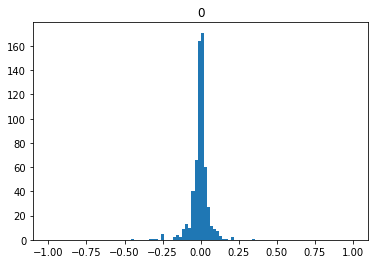

0.3651065370370874


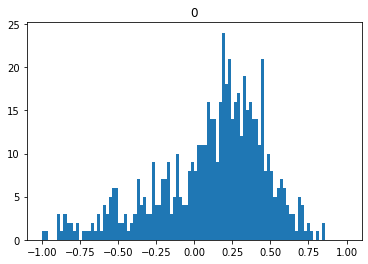

0.3820004897504957


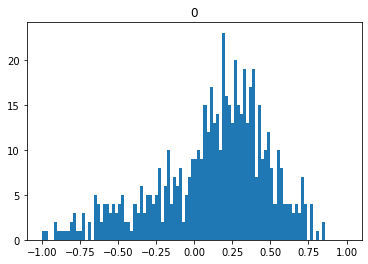

0.03627444824672375


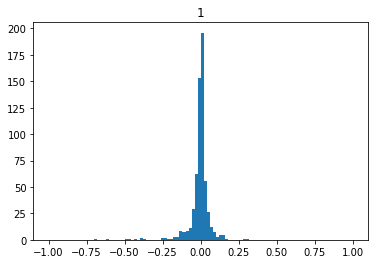

0.37109155950210104


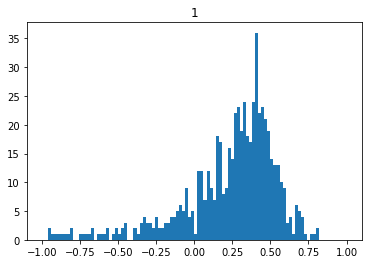

0.3855375615809659


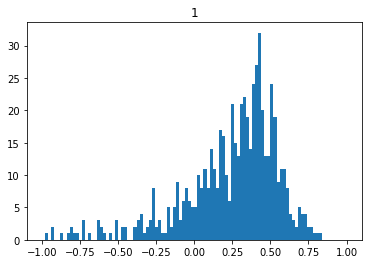

0.048010265078600775


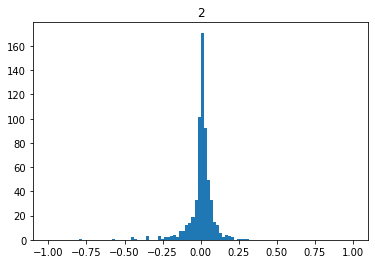

0.4025177333984082


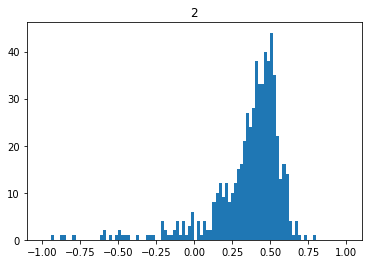

0.42805901058339907


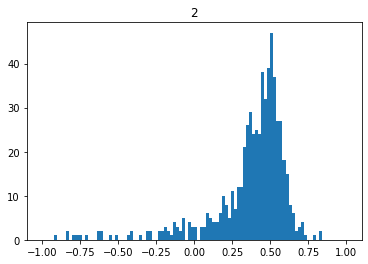

0.05293820924335787


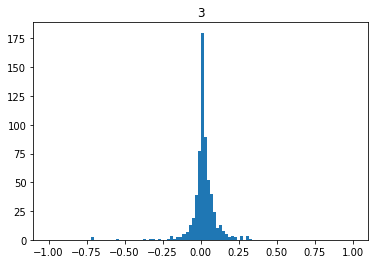

0.466644347022097


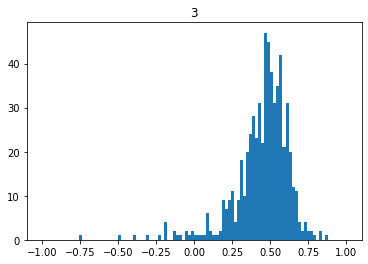

0.4972912848078776


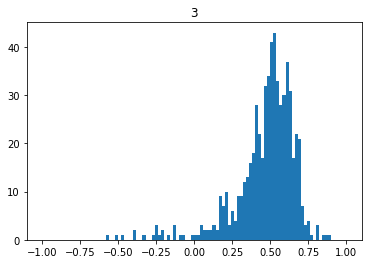

0.04317266258048268


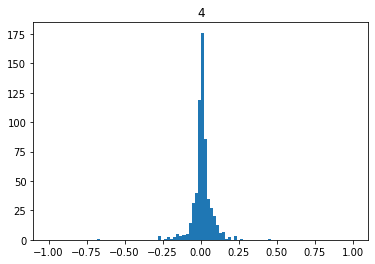

0.37272401116197545


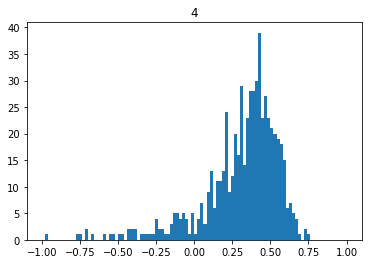

0.3943116637486862


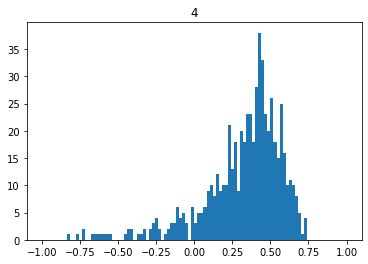

In [11]:
for i in range(len(Data.obs_label)):
    obs = Data.obs_label[i].copy()
    fine_l = Data.finetune_label[i].copy()
    ctm_l = Data.label[i].copy()
    
    obs[Data.obs_label[i]==-999] = 0
    fine_l[Data.obs_label[i]==-999] = 0
    ctm_l[Data.obs_label[i]==-999] = 0
    
    obs = np.sum(obs,axis = 0)
    fine_l = np.sum(fine_l,axis = 0)
    ctm_l = np.sum(ctm_l,axis = 0)

    a = (obs-fine_l)/(obs+1e-3)
    b = (fine_l-ctm_l)/(obs+1e-3)
    c = (obs-ctm_l)/(obs+1e-3)
    
    print(np.mean(np.abs(a[a!=0])))
    plt.hist(a[a!=0].reshape(-1),range=(-1,1),bins = 100)
    plt.title(i)
    plt.show()
    
    plt.hist(b[b!=0].reshape(-1),range=(-1,1),bins = 100)
    print(np.mean(np.abs(b[b!=0])))
    plt.title(i)
    plt.show()
    
    plt.hist(c[c!=0].reshape(-1),range=(-1,1),bins = 100)
    print(np.mean(np.abs(c[c!=0])))
    plt.title(i)
    plt.show()